In [17]:
import glob
import xarray as xr
import netCDF4
import h5netcdf
import scipy
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [25]:
file_paths = glob.glob('/glade/derecho/scratch/geraint/archive/NilsFSAdapt/ice/hist/NilsFSAdapt.cice.h2_01h.0023-02-2*') 
file_paths

[]

In [19]:
ds = xr.open_mfdataset(file_paths, combine='by_coords')

In [20]:
ds

<xarray.Dataset>
Dimensions:           (time: 216, nbnd: 2, nj: 480, ni: 540, nc: 5, nkice: 8,
                       nksnow: 3, nkbio: 5, nkaer: 7, nf: 12, nvertices: 4)
Coordinates:
  * time              (time) object 0023-02-19 23:29:59.780273 ... 0023-02-28...
    TLON              (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    TLAT              (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    ULON              (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    ULAT              (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    NLON              (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    NLAT              (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    ELON              (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    ELAT              (nj, ni) float32 dask.array<chunksize=(480, 540), meta=np.ndarray>
    NCAT              (nc) float32 dask.array<chunksize=(5,), meta=np.ndarray>
    NFSD              (nf) float32 dask.array<chunksize=(12,), meta=np.ndarray>
Dimensions without coordinates: nbnd, nj, ni, nc, nkice, nksnow, nkbio, nkaer,
                                nf, nvertices
Data variables: (12/68)
    time_bounds       (time, nbnd) object dask.array<chunksize=(1, 2), meta=np.ndarray>
    VGRDi             (time, nkice) float32 dask.array<chunksize=(1, 8), meta=np.ndarray>
    VGRDs             (time, nksnow) float32 dask.array<chunksize=(1, 3), meta=np.ndarray>
    VGRDb             (time, nkbio) float32 dask.array<chunksize=(1, 5), meta=np.ndarray>
    VGRDa             (time, nkaer) float32 dask.array<chunksize=(1, 7), meta=np.ndarray>
    tmask             (time, nj, ni) float32 dask.array<chunksize=(1, 480, 540), meta=np.ndarray>
    ...                ...
    before_afsd_seco  (time, nf, nj, ni) float32 dask.array<chunksize=(1, 12, 480, 540), meta=np.ndarray>
    before_afsd_midd  (time, nf, nj, ni) float32 dask.array<chunksize=(1, 12, 480, 540), meta=np.ndarray>
    after_afsd_last_  (time, nf, nj, ni) float32 dask.array<chunksize=(1, 12, 480, 540), meta=np.ndarray>
    after_afsd_secon  (time, nf, nj, ni) float32 dask.array<chunksize=(1, 12, 480, 540), meta=np.ndarray>
    after_afsd_middl  (time, nf, nj, ni) float32 dask.array<chunksize=(1, 12, 480, 540), meta=np.ndarray>
    afsdn_h           (time, nc, nf, nj, ni) float32 dask.array<chunksize=(1, 5, 12, 480, 540), meta=np.ndarray>
Attributes:
    title:               NilsFSAdapt
    contents:            Diagnostic and Prognostic Variables
    source:              CICE Sea Ice Model, unknown_version_name
    comment:             All years have exactly 365 days
    comment2:            File written on model date 00230220
    comment3:            seconds elapsed into model date:      0
    time_period_freq:    hour_1
    time_axis_position:  middle
    conventions:         CF-1.0
    history:             This dataset was created on 2024-10-28 at 19:08
    io_flavor:           io_pio2 cdf1

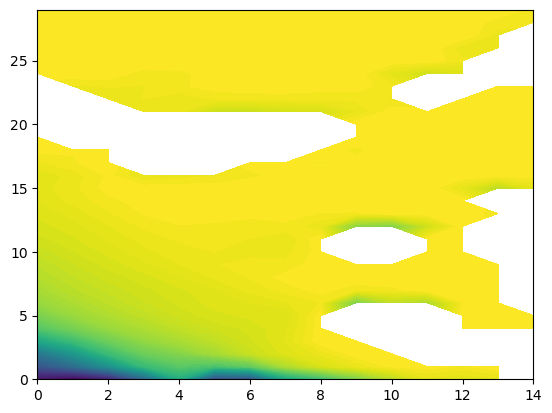

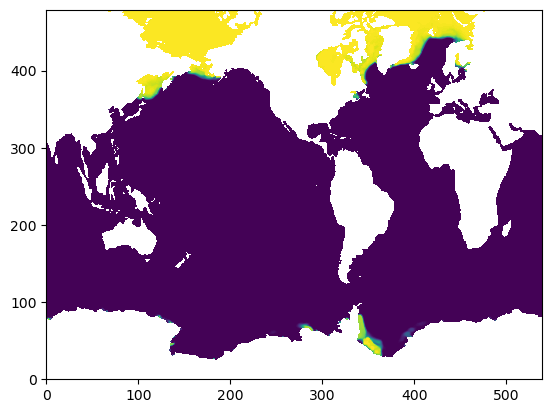

In [21]:
#(120,190)
plt.contourf(ds.aice_h[0].isel(nj=slice(440,470)).isel(ni=slice(450,465)),levels=100)
plt.show()
plt.contourf(ds.aice_h[0],levels=100)

In [22]:
# Initialize empty lists to store the data
latNH=slice(440,470)
longNH=slice(450,465)
dshigh=ds.isel(nj=latNH).isel(ni=longNH)
print(dshigh.dims['nj'])
ds_in = []
ds_out = []

# Loop over each time, nj, and ni
for t in range(len(ds.time)): # Ignore first time step ds.dims['time']
    for j in range(dshigh.dims['nj']):
        for i in range(dshigh.dims['ni']):
            divu = dshigh.divu_h[t, j, i].values / 100
            if divu>0.055: divu=0.0549
            # Check if none of the values are NaNs
            
            if dshigh.aice_h[t,j,i].values>0.1:
                if divu>0.01:
                    # Extract the 12 (nf) values for each variable
                    before_afsd_last = dshigh.before_afsd_last[t, :, j, i].values
                    after_afsd_last_ = dshigh.after_afsd_last_[t, :, j, i].values
                    before_afsd_seco = dshigh.before_afsd_seco[t, :, j, i].values
                    after_afsd_secon = dshigh.after_afsd_secon[t, :, j, i].values
                    before_afsd_midd = dshigh.before_afsd_midd[t, :, j, i].values
                    after_afsd_middl = dshigh.after_afsd_middl[t, :, j, i].values

                    
                    if not (np.isnan(before_afsd_last).any() or np.isnan(after_afsd_last_).any()) and not((before_afsd_last==0).any()): # and before_afsd_midd[-1]>0.1
                        hold1=after_afsd_last_ - before_afsd_last
                        ds_in.append((before_afsd_last, divu))
                        ds_out.append((hold1))
                    
                    
                    if not (np.isnan(before_afsd_seco).any() or np.isnan(after_afsd_secon).any()) and not((before_afsd_seco==0).any()):
                        hold2=after_afsd_secon - before_afsd_seco
                        ds_in.append((before_afsd_seco, divu))
                        ds_out.append((hold2))
                    
                    
                    if not (np.isnan(before_afsd_midd).any() or np.isnan(after_afsd_middl).any()) and not((before_afsd_midd==0).any()):
                        hold3=after_afsd_middl - before_afsd_midd
                        ds_in.append((before_afsd_midd, divu))
                        ds_out.append((hold3))
            
ds_in = np.array([np.append(arr, scalar) for arr, scalar in ds_in])



30


In [23]:
print(len(ds_out))

6357


In [24]:
# Create CSV files for ds_in and ds_out
np.savetxt('ds_in_30RightFranday60.csv', ds_in, delimiter=',')
np.savetxt('ds_out_30RightFranday60.csv', ds_out, delimiter=',')